# Dataset Surtur

In [2]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500


import numpy as np
from glob import glob as globlin
from bs4 import BeautifulSoup
import re
from urlextract import URLExtract
import statistics

from tqdm import tqdm
tqdm.pandas()

import signal
from contextlib import contextmanager

from xgboost import XGBClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot
import plotly.express as px


@contextmanager
def timeout(time):
    # Register a function to raise a TimeoutError on the signal.
    signal.signal(signal.SIGALRM, raise_timeout)
    # Schedule the signal to be sent after ``time``.
    signal.alarm(time)

    try:
        yield
    except TimeoutError:
        return 'timeout error'
    finally:
        # Unregister the signal so it won't be triggered
        # if the timeout is not reached.
        signal.signal(signal.SIGALRM, signal.SIG_IGN)


def raise_timeout(signum, frame):
    raise TimeoutError

## Reading New Data

In [70]:
def read_data(main_path):
    """reading the benign samples"""
    dataframe_array = []
    benign_data_paths = globlin(main_path)
    for path in benign_data_paths:
        dataframe_array.append(pd.read_csv(path))
        #print(pd.read_csv(path).columns)
    return pd.concat(dataframe_array)

In [71]:
dataset_surtur = read_data('./data_construction/4 - final_data/*.csv').drop(columns=['Unnamed: 0.1'])
df_mal_sup = read_data('./data_construction/supp_malicious_1.csv')

/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [72]:
df_mal_sup = df_mal_sup.drop(columns=['Label'])

In [73]:
dataset_surtur = dataset_surtur.drop(columns=['status', 'https.1'])

In [74]:
df_mal_sup.columns = ['url', 'has_IP_in_url', 'number_subdomains', 'hostname',
       'length_hostname', 'ratio_digits_url', 'having_@_in_url',
       'ratio_digits_hostname', 'number_underscores', 'tld', 'url_len',
       'https', 'who_is', 'content', 'label']

df_mal_sup.columns

Index(['url', 'has_IP_in_url', 'number_subdomains', 'hostname',
       'length_hostname', 'ratio_digits_url', 'having_@_in_url',
       'ratio_digits_hostname', 'number_underscores', 'tld', 'url_len',
       'https', 'who_is', 'content', 'label'],
      dtype='object')

In [75]:
dataset_surtur = pd.concat([dataset_surtur, df_mal_sup], axis=0, sort=False).drop_duplicates()
dataset_surtur.head()

,content,has_IP_in_url,having_@_in_url,hostname,https,label,length_hostname,number_subdomains,number_underscores,ratio_digits_hostname,ratio_digits_url,tld,url,url_len,who_is
0,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",0.0,0.0,islandvolleyballclub.com,no,good,24.0,0.0,0.0,0.0,0.0,com,http://islandvolleyballclub.com/venues.html,43.0,complete
1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01//...",0.0,0.0,www.indiosoftware.com,no,good,21.0,1.0,0.0,0.0,0.0,com,http://www.indiosoftware.com/,29.0,complete
2,"<html>\n<head>\n<meta content=""text/html; char...",0.0,0.0,naturalfilters.bizland.com,no,good,26.0,1.0,0.0,0.0,0.0,com,http://naturalfilters.bizland.com/aquarain/,43.0,complete
3,<!DOCTYPE HTML>\n\n<html><!-- InstanceBegin te...,0.0,0.0,www.rosepath.com,no,good,16.0,1.0,0.0,0.0,0.0,com,http://www.rosepath.com,23.0,complete
4,could not fetch content,0.0,0.0,www.plannedparrothood.com,no,good,25.0,1.0,0.0,0.0,0.0,com,http://www.plannedparrothood.com/,33.0,complete


In [76]:
dataset_surtur['label'].value_counts()

good    62843
bad     45139
Name: label, dtype: int64

## Extracting JS

In [77]:
def get_js(content, supp=False):
    tags_of_interest = [
        '<script type="text/javascript">', 
        '<script>'
    ]
    
    soup = BeautifulSoup(content, 'html.parser')
    js = soup.find_all('script')
    complete_js = ''
    for tag in js:
        for tag_int in tags_of_interest:
            if tag_int in str(tag):
                complete_js += str(tag).replace(tag_int, '').replace(
                    '</script>', '')
    return complete_js.encode('utf-8')

In [78]:
dataset_surtur['js'] = dataset_surtur['content'].progress_apply(lambda content: get_js(str(content)))

 83%|████████▎ | 89831/107983 [37:05<01:37, 186.31it/s] /Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:314: UserWarning:

"b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.

100%|██████████| 107983/107983 [39:23<00:00, 45.68it/s] 


## JS Length

In [79]:
dataset_surtur['js_len'] = dataset_surtur['js'].progress_apply(lambda js: len(js))

100%|██████████| 107983/107983 [00:00<00:00, 883759.58it/s] 


In [80]:
ex_string_thing = dataset_surtur[dataset_surtur['js_len']==0].iloc[1]['content']

## Counting Script tag references in html page 

In [81]:
def script_references(js):
    return js.count('<script')/2

In [82]:
dataset_surtur['js_ref'] = dataset_surtur['content'].progress_apply(
    lambda content: script_references(str(content)))

100%|██████████| 107983/107983 [00:02<00:00, 49083.38it/s]


## Getting array lengths from JS 

In [83]:
def get_max_array_length(js):
    array_lengths = re.findall('\(([^\)]+)\)', js)
    if array_lengths == []:
        return 0
    return max([len(i) for i in array_lengths])

def get_avg_array_length(js):
    array_lengths = re.findall('\(([^\)]+)\)', js)
    if array_lengths == []:
        return 0
    return statistics.mean([len(i) for i in array_lengths])

In [84]:
dataset_surtur['js_array_len_avg'] = dataset_surtur['js'].progress_apply(
    lambda js: get_avg_array_length(str(js)))
dataset_surtur['js_array_len_max'] = dataset_surtur['js'].progress_apply(
    lambda js: get_max_array_length(str(js)))

100%|██████████| 107983/107983 [00:03<00:00, 33369.10it/s]


## Content Length

In [85]:
dataset_surtur['content_len'] = dataset_surtur['content'].progress_apply(
    lambda x: len(str(x)))

100%|██████████| 107983/107983 [00:00<00:00, 756119.86it/s]


## Number of Function calls

In [86]:
dataset_surtur['js'][1]

1    b'\nfunction getCookie(c_name) { // Local func...
1                                                  b''
1    b'<!--//<![CDATA[\r\n   var m3_u = (location.p...
1                                                  b''
1    b'\r\n  $(document).ready(function(){\r\n    $...
1    b'<!--\ngoogle_ad_client = "ca-pub-89128049780...
1    b'document.documentElement.className="client-j...
1                                                  b''
1    b'\r\n  window.___gcfg = {lang: \'pl\'};\r\n\r...
1    b'!function(e){function r(r){for(var n,a,i=r[0...
1    b"function myfun(){document.cookie='wtime=1624...
1                                                  b''
1    b'(window.NREUM||(NREUM={})).loader_config={li...
1                                                  b''
1                                                  b''
1    b'\n<!--//\n\nvar _qevents = _qevents || [];\n...
1                                                  b''
1    b'\n                                    docume...
Name: js, 

In [87]:
def get_func_calls(js):
    full_paren = len(re.findall("\(([^\)]+)\)", js))
    empty_paren = len(js.split('()'))
    return full_paren + empty_paren

In [88]:
dataset_surtur['num_js_func_calls'] = dataset_surtur['js'].progress_apply(
    lambda x: get_func_calls(str(x)))

100%|██████████| 107983/107983 [00:03<00:00, 30232.80it/s]


## Suspicious Function Count

In [91]:
def get_sus_js_function_count(js):
    function_list = [
        'setcookie', 'getcookie', 'createxmlhttprequest', 'unescape',
        'document.write', 'element.appendchild', 'dateobject.togmtstring',
        'new activexobject', 'document.createelement', 'getappname',
        'getuseragent', 'window.setinterval', 'window.settimeout',
        'location.assign', 'location.replace', 'eval()', 'string.indexof',
        'string.fromcharcode', 'charat', 'split',
        'string.charcodeat', 'document.writeln', 'document.appendchild',
        'innerhtml', 'insertAdjacentHTML', 'outerhtml', 
    ]

    split_js = js.replace('\n',' ').split(' ')
    counter = 0
    for element in split_js:
        if any(m_function in element.lower() for m_function in function_list):
            counter += 1

    return counter

In [92]:
dataset_surtur['malicious_func_count'] = dataset_surtur['js'].progress_apply(
    lambda js: get_sus_js_function_count(str(js)))

100%|██████████| 107983/107983 [02:04<00:00, 870.14it/s] 


## Get total and external URL count in content

In [93]:
# def find_urls(string, ext_count):
#     # with timeout(1):
#     regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
#     url = re.findall(regex, string)
#     if ext_count:
#         return len(set(url))
#     return len(url)


# # Test Code
# string = 'My Profile: https://auth.geeksforgeeks.org/user/Chinmoy%20Lenka/articles in the portal of http://www.geeksforgeeks.org/'
# print("Urls: ", find_urls(string, False))

In [94]:
def find_urls(string, ext_count):
    extractor = URLExtract()
    urls = extractor.find_urls(string)
    if ext_count: 
        return len(set(urls))
    return len(urls)

string_ex = 'My Profile: https://auth.geeksforgeeks.org/user/Chinmoy%20Lenka/articles in the portal of http://www.geeksforgeeks.org/'
    
print(find_urls(string_ex, False))

2


In [95]:
dataset_surtur['total_url_count'] = dataset_surtur['content'].progress_apply(
    lambda js: find_urls(str(js), False)
)

  1%|▏         | 1472/107983 [07:25<8:57:48,  3.30it/s] 


KeyboardInterrupt: 

In [ ]:
dataset_surtur['ext_url_count'] = dataset_surtur['content'].progress_apply(
    lambda js: find_urls(str(js), True)
)

In [ ]:
dataset_surtur.columns

## More Lexical Features

In [ ]:
dataset_surtur['num_semicolons'] = dataset_surtur['url'].progress_apply(lambda url: url.count(';'))
dataset_surtur['num_zeros'] = dataset_surtur['url'].progress_apply(lambda url: url.count('0'))
dataset_surtur['num_spaces'] = dataset_surtur['url'].progress_apply(lambda url: url.count('%20'))
dataset_surtur['num_hyphens'] = dataset_surtur['url'].progress_apply(lambda url: url.count('-'))
dataset_surtur['num_@s'] = dataset_surtur['url'].progress_apply(lambda url: url.count('@'))
dataset_surtur['num_queries'] = dataset_surtur['url'].progress_apply(lambda url: url.count('?'))
dataset_surtur['num_ampersands'] = dataset_surtur['url'].progress_apply(lambda url: url.count('&'))
dataset_surtur['num_equals'] = dataset_surtur['url'].progress_apply(lambda url: url.count('='))

## Safe Browsing API Judgement

In [101]:
with open('./safebrowsingkey.txt') as f:
    api_key = f.read()

In [ ]:
import requests

key = 'your key here'
URL = "https://sb-ssl.google.com/safebrowsing/api/lookup?client=api&apikey={key}&appver=1.0&pver=3.0&url={url}"


def is_safe(url):
    try:
        response = requests.get(URL.format(key=api_key, url=url))
        return response.text != 'malware'
    except:
        return 'unknown'


print(is_safe('http://addonrock.ru/Debugger.js/'))  # prints False
print(is_safe('http://google.com'))  # prints True


dataset_surtur['google_is_safe'] = dataset_surtur['url'].progress_apply(lambda url: is_safe(url))

  0%|          | 0/107983 [00:00<?, ?it/s]

True
True


  0%|          | 300/107983 [00:30<3:21:13,  8.92it/s]

## Presence in Alexa domains

In [1]:
# import onemillion

# ## Check if they are in the one million

## One hot encoding

In [ ]:
def column_adjustor(dataset_column):
    unique_values = dataset_column.unique()
    return dataset_column.progress_apply(lambda x: np.where(unique_values == x)[0][0])

In [ ]:
dataset_surtur = dataset_surtur.dropna()

In [ ]:
dataset_surtur['who_is'] = column_adjustor(dataset_surtur['who_is'])
dataset_surtur['https'] = column_adjustor(dataset_surtur['https'])
dataset_surtur['tld'] = column_adjustor(dataset_surtur['tld'])

dataset_surtur['label'] = dataset_surtur['label'].progress_apply(
    lambda label: 1 if 'bad' in label else 0)

# Checkpoint 

In [ ]:
dataset_surtur.to_csv('./dataset_surtur.csv', index=False)

In [ ]:
dataset_surtur = pd.read_csv('./dataset_surtur.csv')
dataset_surtur.head()

In [ ]:
dataset_surtur = dataset_surtur[dataset_surtur['content']!='could not fetch content']

In [ ]:
dataset_surtur['label'].value_counts()

## Normalizing 

In [107]:
to_keep = dataset_surtur.drop(
    columns=['url', 'content', 'hostname', 'js', 'label']).columns[::-1]

In [108]:
to_keep = dataset_surtur.drop(
    columns=['url', 'content', 'hostname', 'js', 'label']).columns[::-1]
# 'total_url_count', 'ext_url_count'

x = dataset_surtur[dataset_surtur['label'] == 1][to_keep].copy()  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.values)
df_to_plot_malicious = pd.DataFrame(x_scaled)
df_to_plot_malicious.columns = dataset_surtur[to_keep].columns
df_to_plot_malicious['label'] = 1.0

x = dataset_surtur[dataset_surtur['label'] == 0][to_keep].copy()  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.values)
df_to_plot_benign = pd.DataFrame(x_scaled)
df_to_plot_benign.columns = dataset_surtur[to_keep].columns
df_to_plot_benign['label'] = 0.0

normalized_per_class_dataset = pd.concat([df_to_plot_malicious, df_to_plot_benign], axis=0)

x = dataset_surtur[to_keep].copy()  #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.values)
dataset_surt_norm = pd.DataFrame(x_scaled)
dataset_surt_norm.columns = dataset_surtur[to_keep].columns
dataset_surt_norm['label'] = dataset_surtur['label'].values

## Outlier removal 

In [109]:
# from scipy import stats

# num_df_surt = dataset_surt_norm.select_dtypes(include=["number"])
# cat_df_surt = dataset_surt_norm.select_dtypes(exclude=["number"])

# # idx = np.all(stats.zscore(num_df_surt) < 3, axis=1)

# # dataset_surt_norm_cleaned = pd.concat([num_df_surt.loc[idx], 
# #                                    cat_df_surt.loc[idx]], axis=1)

# Q1 = num_df_surt.quantile(0.10)
# Q3 = num_df_surt.quantile(0.80)
# IQR = Q3 - Q1
# idx = ~((num_df_surt < (Q1 - 1.5 * IQR)) | (num_df_surt > (Q3 + 1.5 * IQR))).any(axis=1)
# dataset_surt_norm_cleaned = pd.concat([num_df_surt.loc[idx], 
#                                     cat_df_surt.loc[idx]], axis=1)

In [110]:
len(dataset_surt_norm_cleaned)

47614

In [114]:
dataset_surtur['label'].value_counts()

0    60216
1    39541
Name: label, dtype: int64

In [49]:
# indexes_to_drop = dataset_surtur.nlargest(15000, 'js_len')['js_len'].index
# dataset_surtur = dataset_surtur.drop(indexes_to_drop, axis='index')

## Feature Analysis

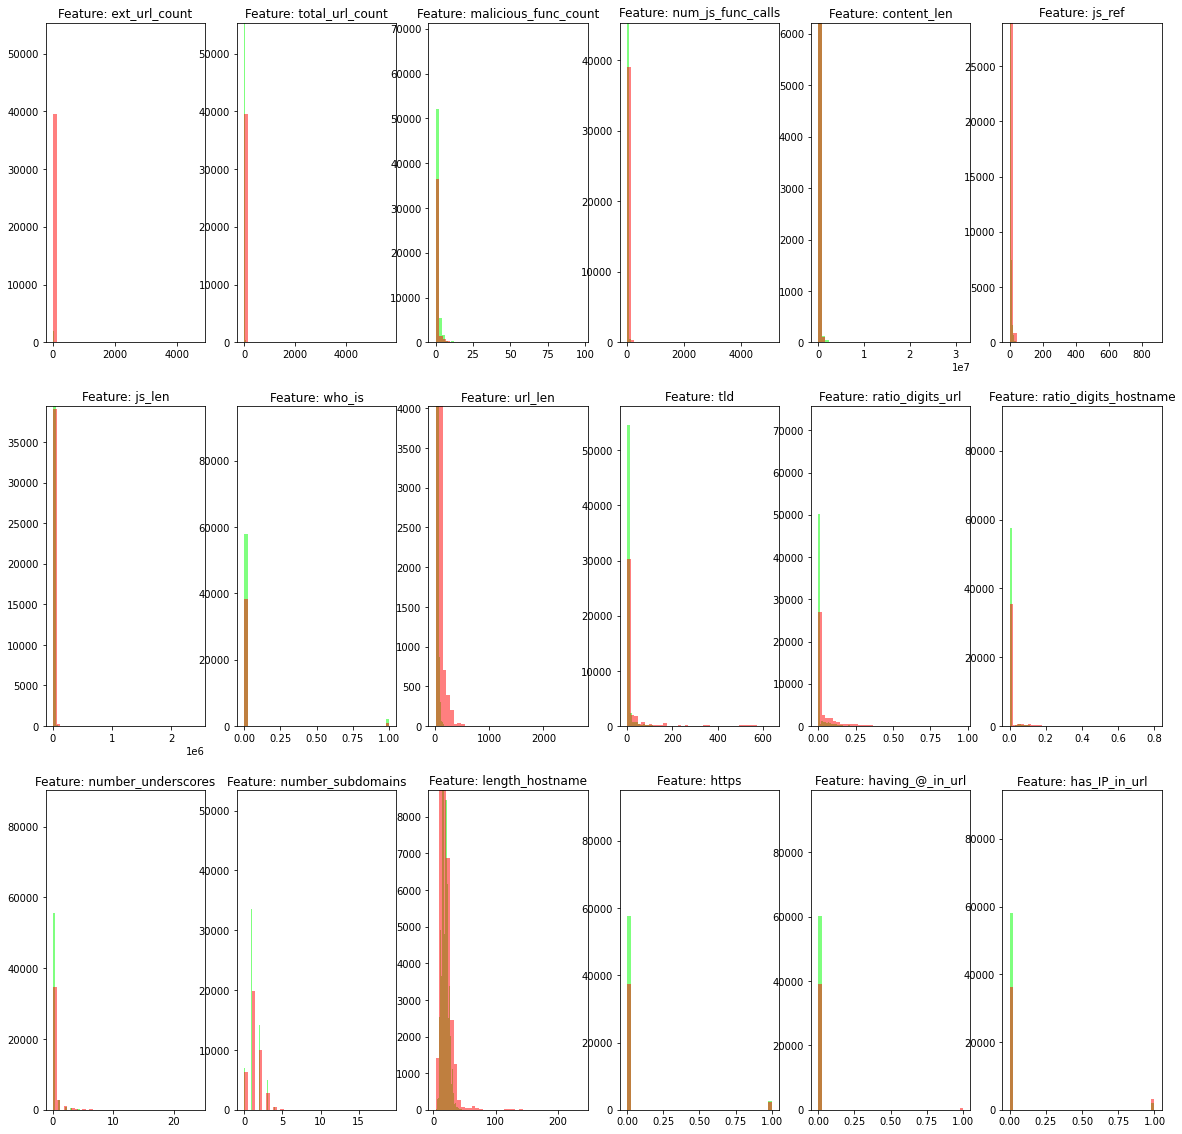

In [116]:
features = dataset_surtur.drop(columns=['url', 'content', 'hostname', 'js', 
                                        'label']).columns[::-1] #, 'total_url_count', 'ext_url_count']).columns[::-1]
df_to_plot = dataset_surtur

n_bins = 40

fig, axs = plt.subplots(3, 6, figsize=(20,20))

# We can set the number of bins with the `bins` kwarg
feature_counter = 0
for i in range(len(axs)):
    for j in range(len(axs[i])): 
        current_feature = df_to_plot[features[feature_counter]]
        axs[i, j].hist(current_feature[df_to_plot['label']==0.0], n_bins, fc=(0, 1, 0, 0.5))
        axs[i, j].hist(current_feature[df_to_plot['label']==1.0], n_bins, fc=(1, 0, 0, 0.5))
        axs[i, j].set_title(f'Feature: {features[feature_counter]}')
        if features[feature_counter] == 'asdf':
            axs[i, j].set_ylim([0, current_feature.value_counts().iloc[0]]) 
        else:
            axs[i, j].set_ylim([0, max(current_feature.value_counts())]) 
        feature_counter += 1
    if feature_counter > 14:
        break

plt.show()

## Plotly Analysis

In [56]:
dataset_surtur.columns

Index(['content', 'has_IP_in_url', 'having_@_in_url', 'hostname', 'https',
       'label', 'length_hostname', 'number_subdomains', 'number_underscores',
       'ratio_digits_hostname', 'ratio_digits_url', 'tld', 'url', 'url_len',
       'who_is', 'js', 'js_len', 'js_ref', 'content_len', 'num_js_func_calls',
       'malicious_func_count', 'total_url_count', 'ext_url_count',
       'js_array_len_avg', 'js_array_len_max', 'num_semicolons', 'num_zeros',
       'num_spaces', 'num_hyphens', 'num_@s', 'num_queries'],
      dtype='object')

In [10]:
# js_array_len_avg

In [63]:
feature = 'js_array_len_max'
# feature = dataset_surt_norm.columns[2]
dataset_to_plot = dataset_surtur

good_filter = dataset_to_plot[feature][dataset_to_plot['label'] == 0]#.progress_apply(lambda x: roundup(x))
bad_filter = dataset_to_plot[feature][dataset_to_plot['label'] == 1]#.progress_apply(lambda x: roundup(x))


# bad_filter = bad_filter[bad_filter!=bad_filter.max()]

trace1 = go.Histogram(
    x=good_filter,
    name='Benign',
    yaxis='y2'

)

trace2 = go.Histogram(
    x=bad_filter,
    name='Malicious',
    yaxis='y2'
)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)

fig['layout'].update(height = 500, width = 800, title = f'Feature: {feature}',xaxis=dict(tickangle=-90))
iplot(fig)

# Machine Learning 

## Standard Set

### Train-test-split

In [64]:
X = dataset_surtur.drop(columns = ['label', 'content', 'hostname', 'url', 
                                   'js']).astype('float32') # 'total_url_count', 'ext_url_count'
y = dataset_surtur['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### XGBoost

In [65]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)

/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[02:00:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
y_pred = xgboost_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8069562575941677

In [67]:
confusion_matrix(y_test, y_pred)

array([[18104,  1833],
       [ 4522,  8461]])

In [68]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.8001    0.9081    0.8507     19937
   malicious     0.8219    0.6517    0.7270     12983

    accuracy                         0.8070     32920
   macro avg     0.8110    0.7799    0.7888     32920
weighted avg     0.8087    0.8070    0.8019     32920



## Checking misclassified samples

In [19]:
# for index, value in enumerate(y_pred):
#     if value != y_test[index]:
#         pass
#         #print(index)

In [20]:
dataset_surtur.iloc[3]

content                  <!DOCTYPE HTML>\n\n<html><!-- InstanceBegin te...
has_IP_in_url                                                            0
having_@_in_url                                                          0
hostname                                                  www.rosepath.com
https                                                                    0
label                                                                    0
length_hostname                                                         16
number_subdomains                                                        1
number_underscores                                                       0
ratio_digits_hostname                                                    0
ratio_digits_url                                                         0
tld                                                                      0
url                                                http://www.rosepath.com
url_len                  

### Random Forest

In [21]:
rfc_model = RandomForestClassifier(max_depth=2, random_state=0)
rfc_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [22]:
y_pred = rfc_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6707168894289186

In [23]:
confusion_matrix(y_test, y_pred)

array([[19515,   422],
       [10418,  2565]])

In [24]:
print(classification_report(y_test, y_pred, 
                            target_names=['benign', 'malicious'], 
                            digits=4))

              precision    recall  f1-score   support

      benign     0.6520    0.9788    0.7826     19937
   malicious     0.8587    0.1976    0.3212     12983

    accuracy                         0.6707     32920
   macro avg     0.7553    0.5882    0.5519     32920
weighted avg     0.7335    0.6707    0.6007     32920



### SVM

In [96]:
param_grid = {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}

svm_model = svm.SVC(verbose=3)
clf = GridSearchCV(svm_model, param_grid, n_jobs=-1, cv=3, verbose=3)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:    3.2s remaining:   35.5s
[Parallel(n_jobs=-1)]: Done  11 out of  24 | elapsed:    3.2s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    3.2s remaining:    0.6s


KeyboardInterrupt: 

In [66]:
print(clf.best_params_)
print(clf.best_estimator_)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1, gamma=0.001, verbose=3)


In [67]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [68]:
confusion_matrix(y_test, y_pred)

array([[19937,     0],
       [    0, 12983]])

In [69]:
print(classification_report(y_test, y_pred, 
                            target_names=['benign', 'malicious'], 
                            digits=4))

              precision    recall  f1-score   support

      benign     1.0000    1.0000    1.0000     19937
   malicious     1.0000    1.0000    1.0000     12983

    accuracy                         1.0000     32920
   macro avg     1.0000    1.0000    1.0000     32920
weighted avg     1.0000    1.0000    1.0000     32920



## Neural Network

In [25]:
X_train.shape

(66837, 20)

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, AveragePooling2D, Flatten, Dropout
from tensorflow.python.client import device_lib

model = Sequential([
#     Conv2D(filters=6,
#            kernel_size=(3, 3),
#            activation='relu',
#            input_shape=X_train.shape),
#     Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
#     AveragePooling2D(),
#     Flatten(),
    Dense(units=1210, activation='relu'),
    Dense(units=841, activation='relu'),
    Dense(units=1, activation='softmax')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_history = model.fit(X_train, y_train, #validation_data=(X_valid_NN, y_valid_NN), 
                          epochs=5, batch_size=32, verbose=True)

Epoch 1/5
2089/2089 [==============================] - 9s 4ms/step - loss: 248.9629 - accuracy: 0.3982
Epoch 2/5
1042/2089 [=============>................] - ETA: 4s - loss: 1.6422 - accuracy: 0.3984

KeyboardInterrupt: 

## Feature Selection - Chi Squared

In [27]:
X_new = SelectKBest(chi2, k=8).fit_transform(X, y)
X_new.shape

(99757, 8)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

### XGBoost

In [29]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)

/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[01:43:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
y_pred = xgboost_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7783718104495747

In [31]:
confusion_matrix(y_test, y_pred)

array([[17909,  2028],
       [ 5268,  7715]])

In [32]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious'], digits=4))

              precision    recall  f1-score   support

      benign     0.7727    0.8983    0.8308     19937
   malicious     0.7919    0.5942    0.6790     12983

    accuracy                         0.7784     32920
   macro avg     0.7823    0.7463    0.7549     32920
weighted avg     0.7803    0.7784    0.7709     32920

